# CITS5508 Lab 3: Classification on Forest Type

Name: Joey Koh<br>
Student number: 21506379  
Date created: 13 April 2020  
Last modified: 20 April 2020  

This notebook goes through the steps of a typical ensemble classifier (voting classifier) project. It is addressing a multi-class classification task on predicting protein localisation sites using various attributes for E.coli.<br>

A Support Vector Machine Classifier, Logistic Regression, and Gradient Descent Classifier are used in ensemble and judged in performance.

- [ ] fix notes
- [ ] search and fix EDIT
- [ ] search and remove all REMOVE

ask:
- how to use drop/loc
- feature scaling using training_x data right?
- accuracy and f1 score difference?
- imbalanced binary, how to deal

## 1. Setup, Data Cleaning and Visualisation
Import libraries to be used and bring the data in. Clean the data for use.<br>
Perform basic visualisations to have a feel of data.<br>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

#Prepare the data, separate cols by whitespace, give col names
raw_data = pd.read_csv("ecoli.data", delim_whitespace = True, header=None, names=['sequence name','mcg','gvh','lip','chg','aac','alm1','alm2','class'])

#View first few lines and inspect columns
raw_data.head()

,sequence name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


These are the first **few lines of data.** Note the **new** column headings.<br>
Looks good, columns are named. We know the first 8 columns are features with the 9th being the class label.

### 1.1 Data Cleaning

In [2]:
#Looking at class distribution
raw_data["class"].value_counts()   #Count instances for class labels

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: class, dtype: int64

From these class value counts.<br>
Let's **remove class labels with less than 10 instances** due to small class sample size making it unfeasible to classify.

In [3]:
#i.e. remove all rows with class= ["imS","imL","omL"]
def clean_data(df): #remove low class instances
    c_df = df[ (df["class"]!="imS") & (df["class"]!="imL") & (df["class"]!="omL") ] #remove rows with class= ["imS","imL","omL"]
    c_df = c_df.reset_index(drop=True) #renumber index
    print("Are there any undefined values created?")
    print(c_df.isnull().values.any()) #ensure no undefined values due to removal
    return c_df

data = clean_data(raw_data)

Are there any undefined values created?
False


Good, no problems here and the index is renumbered.

### 1.2 Visualisations

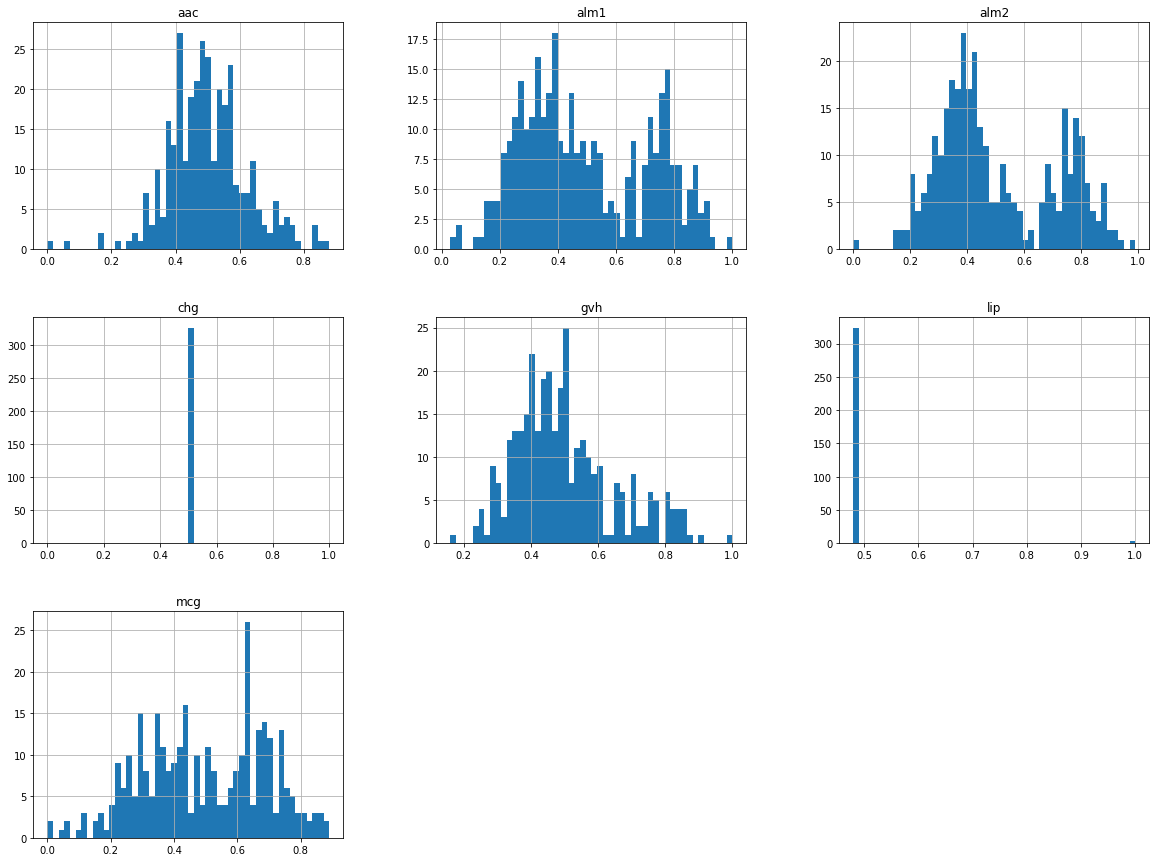

In [4]:
#Generate histograms
data.hist(bins=50, figsize=(20,15))
plt.show()

From these histograms of the training data, it can be observed that:<br>
* "aac", "mcg" and "gvh" attributes are normally distributed with different adherences to the curve.
* "alm1" and "alm2" attributes are normally distributed around two different values each.
* "chg" and "lip" are binary values from the data description. Clearly, heavily imbalanced data for both attributes. With one unique value for "chg" and one 1.0 value for "lip".
* The non-binary attributes have similar scales, but slightly different ranges and adherence to the normal distribution. Feature scaling is likely to provide slightly better results.
* Approximating the median for each attribute to be around the middle of the normal distribution hump, the far tails/heads values could potentially be outliers. It might be better to use StandardScaler rather than MinMaxScaler in data normalisation due to outliers.

In [5]:
print("Number of unique categories in 'sequence name' feature:")
print(data["sequence name"].nunique(),"\n")
print("Binary value distribution in 'chg' feature:")
print(data["chg"].value_counts(), "\n")
print("Binary value distribution in 'lip' feature:")
print(data["lip"].value_counts(), "\n")

print("Value count of class labels now: ")
print(data["class"].value_counts(), "\n")

data.describe() #get a numerical idea of data distribution

Number of unique categories in 'sequence name' feature:
327 

Binary value distribution in 'chg' feature:
0.5    327
Name: chg, dtype: int64 

Binary value distribution in 'lip' feature:
0.48    324
1.00      3
Name: lip, dtype: int64 

Value count of class labels now: 
cp     143
im      77
pp      52
imU     35
om      20
Name: class, dtype: int64 



,mcg,gvh,lip,chg,aac,alm1,alm2
count,327.000000,327.000000,327.000000,327.0,327.000000,327.000000,327.000000
mean,0.494190,0.499939,0.484771,0.5,0.499450,0.497462,0.503119
std,0.193719,0.149935,0.049654,0.0,0.123165,0.217333,0.206947
min,0.000000,0.160000,0.480000,0.5,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.5,0.420000,0.330000,0.350000
50%,0.490000,0.470000,0.480000,0.5,0.490000,0.450000,0.430000
75%,0.655000,0.570000,0.480000,0.5,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,0.5,0.880000,1.000000,0.990000


Taking a closer look at the data, we observe:
- "sequence name" unique non-numerical value count **equals** the data's total number of instances. Hence, it is not very useful for this classification problem. **Let's drop it to simplify the modelling.**
- "chg" binary values are **identical**, and "lip" binary values has a **324:3 ratio**.<br>
From looking at the count of class labels, <b>we clearly have an imbalanced dataset.</b> With 'cp' class having the most instances of 143, relative to the range of 77 to 20 for the other 4 remaining classes.</p>

<p>Class: cp  (cytoplasm), im  (inner membrane without signal sequence), pp  (perisplasm), imU (inner membrane, uncleavable signal sequence), om  (outer membrane) </p>

<p>Looking at the distribution of the values at min, 25%, 50%, 75% and max – in combination to the observations from the histograms, there are likely <b>outliers in attributes</b> which a <b>StandardScaler</b> would deal better with compared to a MinMaxScaler. For this reason, standardization was used in the pipeline to normalise the data. In this, firstly the column's mean value is subtracted from every value in the column, then divided by the standard deviation. The resulting distribution has unit variance. Thus, the outliers has less of an impact compared to MinMax scaling.</p>


In [6]:
#Drop sequence name column
data= data.drop("sequence name", axis=1)

## 2. Pipeline: Data Checking and Normalisation
Split dataset, extract labels, perform feature scaling, and create pipeline.

In [7]:
#EDIT? stratified shuffling?
#Split dataset at 8:2 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state= 42) #with set randomseed
#Ensure no NaN values
print("are there any NaN values created for test data and train data?")
print(test_data.isnull().values.any()," and ",train_data.isnull().values.any() )


are there any NaN values created for test data and train data?
False  and  False


As checked, there are no undefined values after data splitting.

In [8]:
def separate_pipeline(df): #separate data into labels and predictors
    df_y = df["class"]  #Extract class labels
    print("For this dataset, these are the number of instances for each class label")
    print(df_y.value_counts(),"\n")   #Count instances for class labels in training set
    df_x = df.drop("class", axis=1) #separate predictors from labels
    #REMOVE print(df_x.describe(),'\n')  #get an idea of the data distribution
    return df_y, df_x

def scaler_pipeline(df,df_train_x): #for feature scaling
    std_scaler = StandardScaler()
    std_scaler.fit(df_train_x)
    return std_scaler.transform(df)
    
def main_pipeline(train_dataset, test_dataset): #bringing it all together
    print("For the training dataset:\n")
    train_y, train_x = separate_pipeline(train_dataset)
    print("For the testing dataset:\n")
    test_y, test_x = separate_pipeline(test_dataset)
    train_x_tr = scaler_pipeline(train_x, train_x)
    test_x_tr = scaler_pipeline(test_x, train_x)
    return train_y, train_x, test_y, test_x, train_x_tr, test_x_tr

train_y, train_x, test_y, test_x, train_x_tr, test_x_tr = main_pipeline(train_data, test_data)


For the training dataset:

For this dataset, these are the number of instances for each class label
cp     113
im      62
pp      40
imU     29
om      17
Name: class, dtype: int64 

For the testing dataset:

For this dataset, these are the number of instances for each class label
cp     30
im     15
pp     12
imU     6
om      3
Name: class, dtype: int64 



Good, there are some instances for each of the 5 classes to train with.

## 3. Support Vector Classifier
one vs one binary classication on the 5 class labels

In [9]:
#fit SVC model with training data
svm_clf = SVC()
svm_clf.fit(train_x_tr,train_y);

#generate test data label prediction
test_y_svm_pred = svm_clf.predict(test_x_tr)

### 3.1 Confusion Matrix 

In [10]:
def conf_matrix(actual_y, pred_y, model): #confusion matrix function for plotting
    #confusion matrix generation
    conf_mx = confusion_matrix(actual_y, pred_y)
    print("This is the confusion matrix for",model,"\n",conf_mx)

    #visualisation setup
    alpha = ['cp', 'im', 'imU', 'om','pp']
    conf_data = conf_mx

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_data, interpolation='nearest')
    fig.colorbar(cax)

    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)

    plt.show
    print("Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis")
    
def report_scores(actual_y, pred_y): #accuracy and F1 score function
    print("Accuracy score of prediction:\n")
    print(metrics.accuracy_score(actual_y, pred_y),"\n")
    print("F1 scores of prediction for each class:")
    #print("in order of ['cp', 'im', 'imU', 'om','pp']\n")
    print(metrics.f1_score(actual_y, pred_y, average= "micro"))
    

This is the confusion matrix for SVC 
 [[30  0  0  0  0]
 [ 1 13  1  0  0]
 [ 0  3  3  0  0]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


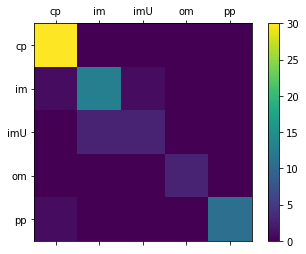

In [11]:
#Confusion matrix for SVC
conf_matrix(test_y,test_y_svm_pred, "SVC")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 13 correctly predicted, 1,1 wrongly predicted as 'cp','imU' respectively
* Class imU: 3 correctly predicted, 3 wrongly predicted as 'im'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 11 correctly predicted, 1 wrongly predicted as 'cp'

In [12]:
#Get scores
report_scores(test_y, test_y_svm_pred)

Accuracy score of prediction:

0.9090909090909091 

F1 scores of prediction for each class:
0.9090909090909091


### 3.2 Tune Hyperparameters with Grid Search

In [13]:
param_grid = {'kernel':('linear', 'rbf', 'poly'), 
              'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':['scale','auto']
             }

svm_clf = SVC()
scorer = sk.metrics.make_scorer(sk.metrics.f1_score, average = 'micro')

grid_search_svm = GridSearchCV(svm_clf, 
                               param_grid, 
                               scoring = scorer,
                               return_train_score = True)

grid_result_svm = grid_search_svm.fit(train_x_tr, train_y)

In [14]:
print('Best Score: ', grid_result_svm.best_score_)
print('Best Params: ', grid_result_svm.best_params_)

Best Score:  0.8850574712643678
Best Params:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


**Results:** looking up the SVC documentation, the best hyperparameters from the gridsearch has a different 'kernel':'linear' compared to the default setting of 'rbf'. Hence, we try it instead.

In [15]:
test_y_svm_pred_tuned = grid_result_svm.predict(test_x_tr) #Get predictions from grid search result

### 3.3 Confusion Matrix after Grid Search

This is the confusion matrix for SVC tuned 
 [[29  0  0  0  1]
 [ 1 14  0  0  0]
 [ 0  2  4  0  0]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


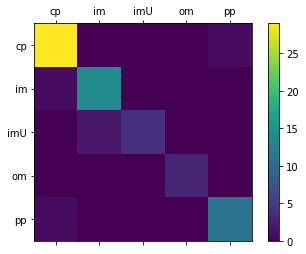

In [16]:
#confusion matrix generation
conf_matrix(test_y, test_y_svm_pred_tuned, "SVC tuned")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 29 correctly predicted, 1 wrongly predicted as 'pp'
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 2 wrongly predicted as 'im'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 11 correctly predicted, 1 wrongly predicted as 'cp'

In [17]:
report_scores(test_y, test_y_svm_pred_tuned)

Accuracy score of prediction:

0.9242424242424242 

F1 scores of prediction for each class:
0.9242424242424242


As the gridsearch results indicate new hyperparameter values as the best in the tested range of values, the accuracy score and confusion matrix **improves** on the un-tuned version's.

## 4. Logistic Regression Classifier

In [18]:
#fit log regression model with training data
log_clf = LogisticRegression()
log_clf.fit(train_x_tr, train_y)

#get test data label predictions
test_y_log_pred = log_clf.predict(test_x_tr)

### 4.1 Confusion Matrix

This is the confusion matrix for log regression 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  1  4  0  1]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


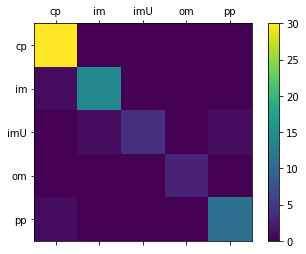

In [19]:
conf_matrix(test_y, test_y_log_pred, "log regression")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1,1 wrongly predicted as 'im','pp' respectively
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 11 correctly predicted, 1 wrongly predicted as 'cp'

In [20]:
report_scores(test_y, test_y_log_pred)

Accuracy score of prediction:

0.9393939393939394 

F1 scores of prediction for each class:
0.9393939393939394


### 4.2 Tune Hyperparameters with Grid Search

In [21]:
param_grid = {'penalty':('l1', 'l2'), 
              'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'intercept_scaling':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
             }

log_clf = LogisticRegression()
scorer = sk.metrics.make_scorer(sk.metrics.f1_score, average = 'micro')

grid_search_log = GridSearchCV(log_clf, 
                               param_grid, 
                               scoring = scorer,
                               return_train_score = True)

grid_result_log = grid_search_log.fit(train_x_tr, train_y)

In [22]:
print('Best Score: ', grid_result_log.best_score_)
print('Best Params: ', grid_result_log.best_params_)

Best Score:  0.8773946360153256
Best Params:  {'C': 1, 'intercept_scaling': 1, 'penalty': 'l1'}


**Results:** looking up the LogReg documentation, the best hyperparameters from the gridsearch has a different 'penalty':'l1' compared to the default setting of 'l2'. Hence, we try it instead.

In [23]:
test_y_log_pred_tuned = grid_result_log.predict(test_x_tr) #Get predictions from grid search result

### 4.3 Confusion Matrix after Grid Search

This is the confusion matrix for Log tuned 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  1  4  0  1]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


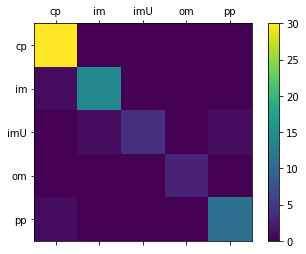

In [24]:
#confusion matrix generation
conf_matrix(test_y, test_y_log_pred_tuned, "Log tuned")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1,1 wrongly predicted as 'im','pp' respectively
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 11 correctly predicted, 1 wrongly predicted as 'cp'

In [25]:
report_scores(test_y, test_y_log_pred_tuned)

Accuracy score of prediction:

0.9393939393939394 

F1 scores of prediction for each class:
0.9393939393939394


As the gridsearch results indicate new hyperparameter values as the best in the tested range of values, the accuracy score and confusion matrix **should improve** on the un-tuned version's. But it doesn't appear to be so, with similar scores.


## 5. Stochastic Gradient Descent Classifier

In [26]:
#fit SGD model with training data
sgd_clf = SGDClassifier(random_state= 63) #set a randomseed
sgd_clf.fit(train_x_tr, train_y);

#generate test data label prediction
test_y_sgd_pred = sgd_clf.predict(test_x_tr)

### 5.1 Confusion Matrix 

This is the confusion matrix for SGD 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  4  1  0  1]
 [ 0  0  0  3  0]
 [ 1  1  0  0 10]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


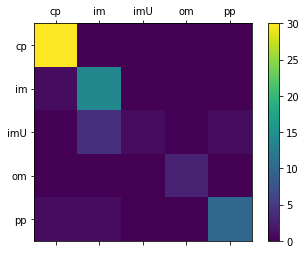

In [27]:
#confusion matrix generation
conf_matrix(test_y, test_y_sgd_pred, "SGD")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 1 correctly predicted, 4,1 wrongly predicted as 'im','pp'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 10 correctly predicted, 1,1 wrongly predicted as 'cp','im'

In [28]:
report_scores(test_y, test_y_sgd_pred)

Accuracy score of prediction:

0.8787878787878788 

F1 scores of prediction for each class:
0.8787878787878788


### 5.2 Tune Hyperparameters with Grid Search

In [29]:
param_grid = {'loss':('hinge', 'log', 'modified_huber', 'perceptron'), 
              'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l2','l1','elasticnet'],
              'random_state':[63]
             }

sgd_clf = SGDClassifier()
scorer = sk.metrics.make_scorer(sk.metrics.f1_score, average = 'micro')

grid_search_sgd = GridSearchCV(sgd_clf, 
                               param_grid, 
                               scoring = scorer,
                               return_train_score = True)

grid_result_sgd = grid_search_sgd.fit(train_x_tr, train_y)

In [30]:
print('Best Score: ', grid_result_sgd.best_score_)
print('Best Params: ', grid_result_sgd.best_params_)

Best Score:  0.8850574712643678
Best Params:  {'alpha': 0.01, 'loss': 'log', 'penalty': 'l1', 'random_state': 63}


**Results:** looking up the SGDClassifier documentation, the default hyperparameters would be {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}. As the grid search result is not identical, we should expect a better performance from the tuned settings. Hence, the accuracy and confusion matrix should be different.

In [31]:
test_y_sgd_pred_tuned = grid_result_sgd.predict(test_x_tr) #Get predictions from grid search result

### 5.3 Confusion Matrix after Grid Search

This is the confusion matrix for SGD tuned 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  1  4  0  1]
 [ 0  0  0  3  0]
 [ 2  0  0  0 10]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


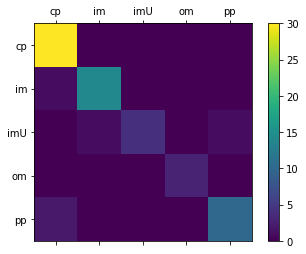

In [32]:
#confusion matrix generation
conf_matrix(test_y, test_y_sgd_pred_tuned, "SGD tuned")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1 wrongly predicted as 'im'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 10 correctly predicted, 2 wrongly predicted as 'cp'

In [33]:
report_scores(test_y,test_y_sgd_pred_tuned)

Accuracy score of prediction:

0.9242424242424242 

F1 scores of prediction for each class:
0.9242424242424242


As the gridsearch results indicate new hyperparameter values as the best in the tested range of values, the accuracy score and confusion matrix **has improved** on the un-tuned version's


## 6. Voting Classifier

In [34]:
#REMOVE
#create and fit training data with voting classifier
voting_clf = VotingClassifier(
    estimators=[('svc', svm_clf), ('lr', log_clf), ('sgd', sgd_clf)],
    voting='hard')
voting_clf.fit(train_x_tr, train_y)

#generate test data label prediction
test_y_voting_pred = voting_clf.predict(test_x_tr)

In [35]:
#REMOVE
#Check each classfier's accuracy scores used in voting_clf
for clf in (svm_clf, log_clf, sgd_clf, voting_clf):
    clf.fit(train_x_tr, train_y)
    checking_y_pred = clf.predict(test_x_tr)
    print(clf.__class__.__name__, sk.metrics.accuracy_score(test_y, checking_y_pred))

SVC 0.9090909090909091
LogisticRegression 0.9393939393939394
SGDClassifier 0.8333333333333334
VotingClassifier 0.9242424242424242


In [36]:
#create and fit training data with voting classifier
voting_clf = VotingClassifier(
    estimators=[('svc', grid_search_svm), ('lr', grid_search_log), ('sgd', grid_search_sgd)],
    voting='hard')
voting_clf.fit(train_x_tr, train_y)

#generate test data label prediction
test_y_voting_pred = voting_clf.predict(test_x_tr)


In [37]:
#Check each classfier's accuracy scores used in voting_clf
for clf in (svm_clf, log_clf, sgd_clf, voting_clf):
    clf.fit(train_x_tr, train_y)
    checking_y_pred = clf.predict(test_x_tr)
    print(clf.__class__.__name__, sk.metrics.accuracy_score(test_y, checking_y_pred))

SVC 0.9090909090909091
LogisticRegression 0.9393939393939394
SGDClassifier 0.8787878787878788
VotingClassifier 0.9393939393939394


This is the confusion matrix for voting classifier 
 [[30  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0  1  4  0  1]
 [ 0  0  0  3  0]
 [ 1  0  0  0 11]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


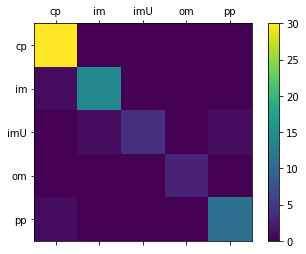

In [38]:
#generate confusion matrix
conf_matrix(test_y, test_y_voting_pred, "voting classifier")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1 wrongly predicted as 'im'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 10 correctly predicted, 1 wrongly predicted as 'cp'

In [40]:
report_scores(test_y, test_y_voting_pred)

Accuracy score of prediction:

0.9393939393939394 

F1 scores of prediction for each class:
0.9393939393939394


## 7. Conclusion

<p>The accuracy score of the untuned and tuned Support Vector Classifier were identical, at 91.9%. This was due to the hyperparameters from the grid search matching the default hyperparameters.</p>

<p>The accuracy score of the untuned Stochastic Gradient Descent Classifier was 93.4%, while the tuned version had a score of 90.9%. As the grid search's resulting hyperparameters were not identical to the default settings, this change is expected. The accuracy score, and thus performance, was found to be lower. However, this is due to the system ending up fine-tuned to perform well on the validation data and it is unlikely to perform as well on unknown datasets. Trying to manually tweak the parameters to make the performance look good on the test dataset would result in the changes being unlikely to generalise well with any new data.
</p>

<p>Overall, the performance of the Support Vector Classifier is comparable to the Stochastic Gradient Descent Classifier.</p>